In [23]:
!git clone https://github.com/LizaDerb/probing_compositionality/

fatal: destination path 'probing_compositionality' already exists and is not an empty directory.


# Датасет

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
rus = pd.read_csv('/content/probing_compositionality/data/rus/extended_vp_corpus.csv', sep=';')
rus = rus[['mwe', 'label', 'short_sentence']].rename(columns={'short_sentence' : 'sentence'})
rus.head()

,mwe,label,sentence
0,жирно будет,I,"Нет, о ""пятерке"" говорить конечно даже не прих..."
1,жирно будет,I,"В том роде, как тогда на Фотьянке. Так вот как..."
2,жирно будет,I,"Больше не проси, потому,-- не дам: больно жирн..."
3,жирно будет,I,Отпущу я его на заработки! А самому небось бат...
4,жирно будет,I,"-- Ну, уж слуга покорный! -- огрызнулся Сарма..."


In [26]:
num_idiom = rus['mwe'].value_counts()
idiom_train = num_idiom[:14].index.tolist()
idiom_test = num_idiom[14:].index.tolist()

rus_train = rus[rus['mwe'].isin(idiom_train)]
rus_test = rus[rus['mwe'].isin(idiom_test)]

rus_train = rus_train.dropna()

print('train: ', len(rus_train))
print('test: ', len(rus_test))

train:  830
test:  445


In [27]:
stat_train_rus = rus_train['label'].value_counts().rename('num').to_frame()
stat_train_rus['percentage'] = (stat_train_rus.num * 100 / stat_train_rus.num.sum()).round(1).astype(str) + '%'
stat_train_rus

,num,percentage
label,,
I,488,58.8%
L,342,41.2%


In [28]:
stat_test_rus = rus_test['label'].value_counts().rename('num').to_frame()
stat_test_rus['percentage'] = (stat_test_rus.num * 100 / stat_test_rus.num.sum()).round(1).astype(str) + '%'
stat_test_rus

,num,percentage
label,,
I,263,59.1%
L,182,40.9%


# Модель

In [29]:
!pip install datasets

In [30]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

In [31]:
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import warnings
import random
import pickle

import torch
from torch.utils.data import DataLoader

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModel

In [32]:
train = Dataset.from_pandas(rus_train)
test = Dataset.from_pandas(rus_test)

In [33]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [34]:
train_labels = le.transform(train['label'])
test_labels = le.transform(test['label'])

In [35]:
rubert_tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
rubert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertMo

In [36]:
torch.cuda.is_available()

True

In [37]:
device_cuda = torch.device("cuda")
device_cpu = torch.device("cpu")

In [40]:
def vectorize_dataset(data, tokenizer, model, num):
    model = model.to(device_cuda)
    res_cls = []
    res_mean = []
    for batch in tqdm(data):
        toks = tokenizer(batch['sentence'], padding='max_length', truncation=True, return_tensors='pt', max_length=300)
        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in toks.items()}, output_hidden_states=True)
            res_cls.append(model_output.hidden_states[num][:,0,:]) #достаём вектора для CLS токенов
            res_mean.append(torch.mean(model_output.hidden_states[num], dim=1)) #среднее
    res_cls = torch.vstack(res_cls)
    res_mean = torch.vstack(res_mean)
    return res_cls.detach().cpu().numpy(), res_mean.detach().cpu().numpy()

In [41]:
dl_train = DataLoader(train, batch_size=256, shuffle=False,
                drop_last=False)
dl_test = DataLoader(test, batch_size=256, shuffle=False,
                drop_last=False)

train_cls = []
train_mean = []
test_cls = []
test_mean = []
for n in range(1, 13):
    vecs_train_cls, vecs_train_mean = vectorize_dataset(dl_train, rubert_tokenizer, rubert, n)
    vecs_test_cls, vecs_test_mean = vectorize_dataset(dl_test, rubert_tokenizer, rubert, n)
    train_cls.append(vecs_train_cls)
    train_mean.append(vecs_train_mean)
    test_cls.append(vecs_test_cls)
    test_mean.append(vecs_test_mean)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [42]:
vectors = {'vecs_train_cls' : train_cls, 'vecs_train_mean' : train_mean,
           'vecs_test_cls' : test_cls, 'vecs_test_mean' : test_mean}

for name in vectors.keys():
    with open(f'{name}.pkl', 'wb') as file:
         pickle.dump(vectors[name], file)

In [43]:
vector_names = ['vecs_train_cls', 'vecs_train_mean', 'vecs_test_cls', 'vecs_test_mean']
vecs = []

for name in vector_names:
    with open(f'{name}.pkl', "rb") as fIn:
        vecs.append(pickle.load(fIn))

train_cls = vecs[0]
train_mean = vecs[1]
test_cls = vecs[2]
test_mean = vecs[3]

In [45]:
len(train_cls)

12

In [46]:
train_cls[0].shape

(830, 768)

In [47]:
def calculate_metrics(true_labels, predictions):
    matrix = confusion_matrix(true_labels, predictions)
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)
    return matrix, acc, prec, rec, f1, roc_auc

In [55]:
def get_results(train_data, train_labels, test_data, test_labels):
    results_train = []
    results_test = []
    for n in tqdm(range(12)):
        clf = MLPClassifier(random_state=42, max_iter=300, verbose=1)
        clf.fit(train_data[n], train_labels)
        train_pred = clf.predict(train_data[n])
        test_pred = clf.predict(test_data[n])
        results_train.append(calculate_metrics(train_labels, train_pred))
        results_test.append(calculate_metrics(test_labels, test_pred))
    return results_train, results_test, test_pred

In [ ]:
results_train_mean, results_test_mean, test_pred_mean = get_results(train_mean, train_labels, test_mean, test_labels)
res_test_mean = pd.DataFrame(results_test_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_mean = pd.DataFrame(results_train_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_mean.to_csv('res_test_mean.csv')
res_train_mean.to_csv('res_train_mean.csv')

In [57]:
print(classification_report(test_labels, test_pred_mean, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.78      0.79      0.79       263
           L       0.70      0.68      0.69       182

    accuracy                           0.75       445
   macro avg       0.74      0.74      0.74       445
weighted avg       0.75      0.75      0.75       445



In [65]:
res_train_mean[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

,accuracy,precision,recall,f1,roc_auc
0,0.819277,0.765193,0.809942,0.786932,0.817881
1,0.891566,0.953237,0.774854,0.854839,0.874107
2,0.977108,0.996923,0.947368,0.971514,0.972660
3,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
res_test_mean[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

,accuracy,precision,recall,f1,roc_auc
0,0.795506,0.715640,0.829670,0.768448,0.800767
1,0.779775,0.804348,0.609890,0.693750,0.753614
2,0.757303,0.715116,0.675824,0.694915,0.744756
3,0.786517,0.737705,0.741758,0.739726,0.779624
4,0.773034,0.703518,0.769231,0.734908,0.772448
5,0.782022,0.732240,0.736264,0.734247,0.774976
6,0.761798,0.702128,0.725275,0.713514,0.756173
7,0.759551,0.698413,0.725275,0.711590,0.754272
8,0.750562,0.680203,0.736264,0.707124,0.748360
9,0.764045,0.699482,0.741758,0.720000,0.760613


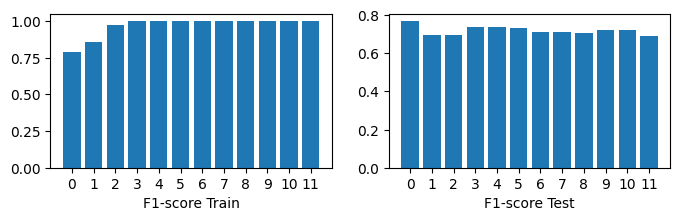

In [102]:
x = range(12)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
ax[0].bar(x, res_train_mean['f1'])
ax[0].set_xlabel('F1-score Train')
ax[0].set_xticks(x, res_train_mean['f1'].index, rotation='horizontal')
ax[1].bar(x, res_test_mean['f1'])
ax[1].set_xlabel('F1-score Test')
ax[1].set_xticks(x, res_test_mean['f1'].index, rotation='horizontal')
plt.show()

In [ ]:
results_train_cls, results_test_cls, test_pred_cls = get_results(train_cls, train_labels, test_cls, test_labels)
res_test_cls = pd.DataFrame(results_test_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_cls = pd.DataFrame(results_train_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_cls.to_csv('res_test_cls.csv')
res_train_cls.to_csv('res_train_cls.csv')

In [59]:
print(classification_report(test_labels, test_pred_cls, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.81      0.82      0.81       263
           L       0.73      0.71      0.72       182

    accuracy                           0.78       445
   macro avg       0.77      0.77      0.77       445
weighted avg       0.78      0.78      0.78       445



In [69]:
res_train_cls[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

,accuracy,precision,recall,f1,roc_auc
0,0.784337,0.782007,0.660819,0.716323,0.765860
1,0.820482,0.789790,0.769006,0.779259,0.812782
2,0.842169,0.886447,0.707602,0.786992,0.822039
3,0.850602,0.811429,0.830409,0.820809,0.847582
4,0.987952,0.982558,0.988304,0.985423,0.988005
5,0.998795,1.000000,0.997076,0.998536,0.998538
6,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
res_test_cls[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

,accuracy,precision,recall,f1,roc_auc
0,0.746067,0.709091,0.642857,0.674352,0.730174
1,0.750562,0.689840,0.708791,0.699187,0.744129
2,0.759551,0.751678,0.615385,0.676737,0.737350
3,0.779775,0.716495,0.763736,0.739362,0.777305
4,0.766292,0.685714,0.791209,0.734694,0.770129
5,0.773034,0.714286,0.741758,0.727763,0.768218
6,0.784270,0.726316,0.758242,0.741935,0.780262
7,0.782022,0.732240,0.736264,0.734247,0.774976
8,0.768539,0.713514,0.725275,0.719346,0.761877
9,0.793258,0.734375,0.774725,0.754011,0.790404


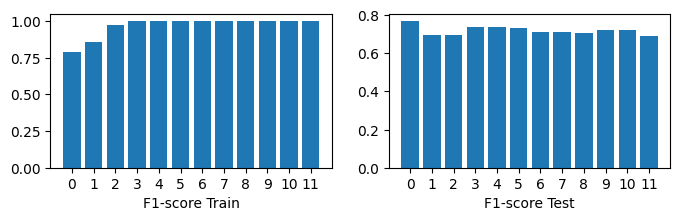

In [103]:
x = range(12)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
ax[0].bar(x, res_train_mean['f1'])
ax[0].set_xlabel('F1-score Train')
ax[0].set_xticks(x, res_train_cls['f1'].index, rotation='horizontal')
ax[1].bar(x, res_test_mean['f1'])
ax[1].set_xlabel('F1-score Test')
ax[1].set_xticks(x, res_test_cls['f1'].index, rotation='horizontal')
plt.show()

In [71]:
!zip -r /content/file.zip /content/layers_rus_rubert

  adding: content/layers_rus_rubert/ (stored 0%)
  adding: content/layers_rus_rubert/vecs_test_mean.pkl (deflated 8%)
  adding: content/layers_rus_rubert/res_train_cls.csv (deflated 63%)
  adding: content/layers_rus_rubert/vecs_test_cls.pkl (deflated 7%)
  adding: content/layers_rus_rubert/res_train_mean.csv (deflated 66%)
  adding: content/layers_rus_rubert/res_test_mean.csv (deflated 57%)
  adding: content/layers_rus_rubert/vecs_train_mean.pkl (deflated 8%)
  adding: content/layers_rus_rubert/vecs_train_cls.pkl (deflated 8%)
  adding: content/layers_rus_rubert/res_test_cls.csv (deflated 56%)
